This Notebook will demonstrate how to Use Orbitize!: A Package for Orbit-Fitting of Directly Imaged Objects by Sarah Blunt, Jason Wang, Henry Ngo, Isabel Angelo, et al. The original version of this notebook can be found at https://orbitize.info/en/latest/installation.html#for-users. The notebook you are viewing has been slightly edited and new comments have been added by Carlos E. Cruz-Arce.

In [1]:
#First you'll need to make sure you have Xcode installed. You can google that, Mac users can find Xcode in the app store.
##you'll also need to pip install cython and orbitize, of course.
#pip install bs4                     #See comment below
#pip install numpy cython --upgrade  #cython may ask you to "pip install bs4"
#pip install orbitize

Other packages you'll need: 
* astropy>=4
* numpy
* scipy
* emcee>=3
* ptemcee
* matplotlib
* corner
* h5py
* deprecation
* cython
* pytest
* pandas
* radvel
* pyerfa

We will start with the "Quick Start" tab of the tutorial page. This will go through the most minimal code it takes to do an orbit fit with Orbitize!

In [2]:
import orbitize                                          #Import what we will need

path_to_file = '{}/GJ504.csv'.format(orbitize.DATADIR)   #This .csv file was downloaded when we pip installed orbitize

print(path_to_file)

/opt/anaconda3/lib/python3.8/site-packages/orbitize/example_data//GJ504.csv


So what did we even download? Let's see what this file looks like. Orbitize comes with a file reader.

In [3]:
from orbitize import read_input      #Importet file reader

read_input.read_file(path_to_file)   #Prints the file you read in above

#Epoch: in MJD
#object: 0 is the primary/central object so 1 would be a planet while 0 would be the star
#quant1: Separation in milliarcseconds 
#quant1_err: Error in Separation 
#quant2: Position Angle in degrees East to NCP
#quant2_Err: Error in Position Angle
#quant_type: "Seppa" meaning the file is in terms of sep and PA. "radec" corresponds to Right Ascension and Declination (units of mas and degress). "rv" corresponds to radial velocity (units of km/s)

epoch,object,quant1,quant1_err,quant2,quant2_err,quant_type,instrument
float64,int64,float64,float64,float64,float64,bytes5,bytes5
55645.95,1,2479.0,16.0,327.94,0.39,seppa,defsp
55702.89,1,2483.0,8.0,327.45,0.19,seppa,defsp
55785.015,1,2481.0,33.0,326.84,0.94,seppa,defsp
55787.935,1,2448.0,24.0,325.82,0.66,seppa,defsp
55985.19400184,1,2483.0,15.0,326.46,0.36,seppa,defsp
56029.11400323,1,2487.0,8.0,326.54,0.18,seppa,defsp
56072.30200459,1,2499.0,26.0,326.14,0.61,seppa,defsp


Can orbitize read in any ol' file? No. 
orbitize.read_input.read_file() can only read file formats supported by astropy.io.ascii.read(). This includes .csv format.

There are 2 options the input data you plan to read in. 
1. As Observations: You can provide your observations in one of the following valid sets of measurements using the corresponding column names:
* RA and DEC offsets [milliarcseconds], using column names raoff, raoff_err, decoff, and decoff_err; or
* sep [milliarcseconds] and PA [degrees East of NCP], using column names sep, sep_err, pa, and pa_err; or
* RV measurement [km/s] using column names rv and rv_err.
* Each row must also have a corresponding epoch column and object column. Epoch should be in MJD. If it's in JD or Orbitize thinks its in JD it will print out a warning and attempt to convert JD to MJD. *** You can use Barycorrpy hosted on EMAC (https://emac.gsfc.nasa.gov#100028c0-a2a3-42ac-a8da-5364dc9de264) to do this conversion without Orbitize in case you want to double check. 
* You can mix and match the 3 valid measurement formats as long as you keep them seperated by object number. For example, "if you have, for example, one RV measurement of a star and three astrometric measurements of an orbiting planet, you should put 0 in the object column for the RV point, and 1 in the columns for the astrometric measurements."

2. As orbitize!-formatted input table: you can also supply a data file with the columns already corresponding to the orbitize!-formatted input table (see raw cell below for example). This may be useful if you are wanting to use the output of the write_orbitize_input method (e.g. using some input prepared by another orbitize! user).

Orbit Fit:

WARNING

The warning you see here is expected. It thinks some of the input dates may be in the wrong format b/c its computing some really far into the future dates but in this case our input dates are in the correct format which is in MJD


: ErfaWarning: ERFA function "dtf2d" yielded 63 of "dubious year (Note 6)" [astropy._erfa.core]


<Figure size 1008x432 with 0 Axes>

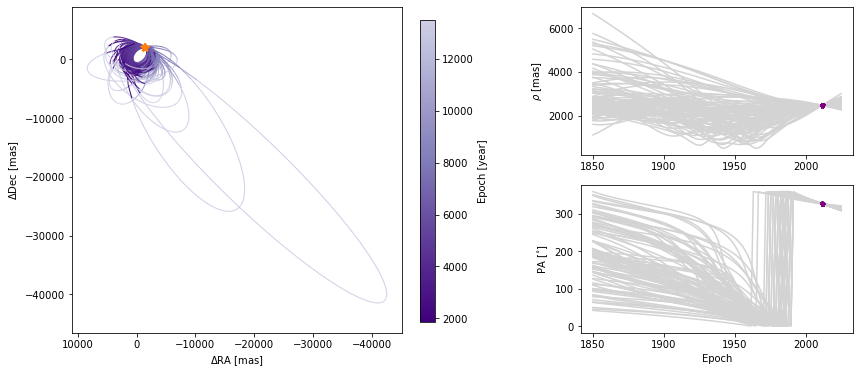

In [4]:
%matplotlib inline

from orbitize import driver

myDriver = driver.Driver(
    '{}/GJ504.csv'.format(orbitize.DATADIR), # data file
    'OFTI',        # choose from: ['OFTI', 'MCMC'] ##OFTI = Orbits for the Impatient, MCMC - Markov Chain MonteCarlo
    1,             # number of planets in system  
    1.22,          # total system mass [M_sun]
    56.95,         # system parallax [mas]
    mass_err=0.08, # mass error [M_sun]
    plx_err=0.26   # parallax error [mas]
)
orbits = myDriver.sampler.run_sampler(10000)

# plot the results
myResults = myDriver.sampler.results
orbit_figure = myResults.plot_orbits(
    start_mjd=myDriver.sampler.epochs[0] # minimum MJD for colorbar (choose first data epoch)
)
print("The warning you see here is expected. It thinks some of the input dates may be in the wrong format b/c its computing some really far into the future dates but in this case our input dates are in the correct format which is in MJD")

So what just happened? Orbitize predicted about 10,000 orbits given a 7x8 data set!

OFTI (Orbits For The Impatient) 
*an orbit-generating algorithm designed specifically to handle data covering short fractions of long-period exoplanets (Blunt et al. 2017). Here we go through steps of using OFTI within orbitize!

In [7]:
#Set a Driver object with your data.
myDriver1 = orbitize.driver.Driver('{}/GJ504.csv'.format(orbitize.DATADIR), # path to data file
                                  'OFTI', # name of algorithm for orbit-fitting
                                  1, # number of secondary bodies in system
                                  1.22, # total system mass [M_sun]
                                  56.95, # total parallax of system [mas]
                                  mass_err=0.08, # mass error [M_sun]
                                  plx_err=0.26) # parallax error [mas]

In [8]:
#Here we generate 1,000,000 orbits
s = myDriver1.sampler              #myDriver is an object class within Orbitize so we can assign all of its attributes to the variable s
orbits1 = s.run_sampler(10000)   #For clean corner plots they recommend we set this to at least 1,000,000.
                                  #For the sake of understanding this notebook you should set it to 10,000 or so

In [9]:
#let's see what one of these orbits looks like
orbits1[0]
#the array "orbits" is 1000000 x 8. 

array([4.81138638e+01, 8.11887727e-02, 2.61027464e+00, 3.13737572e+00,
       2.33495053e+00, 7.80961154e-03, 5.65715544e+01, 1.24810010e+00])

In [10]:
#What are each of the 8 elements in the orbits[0] array?
s.system.param_idx  #Systems Parameters Index, a dictionary of your indices

{'sma1': 0,
 'ecc1': 1,
 'inc1': 2,
 'aop1': 3,
 'pan1': 4,
 'tau1': 5,
 'plx': 6,
 'mtot': 7}

Defining the Indices:
* 'sma1': 0 = Semi-major Axis
* 'ecc1': 1 = Eccentricity
* 'inc1': 2 = Inclination
* 'aop1': 3 = Arguement of Periastron , Periastron: the point nearest to a star in the path of a body orbiting that star.
* 'pan1': 4 = Position Angle of Nodes 
* 'tau1': 5 = Epoch of Periastron Passage
* 'plx':  6 = Parallax
* 'mtot': 7 = System Mass
* the number following the index name corresponds to the number of the body in the system. So in this example is corresponds to planet 1 or GJ 504 b. The number following ":" is just what arguement number it is in the array.

Now that we have generated all of these orbits we'll want to see the statistical significance of the orbits. So let's make some histograms and a corner plot.

Histograms: 

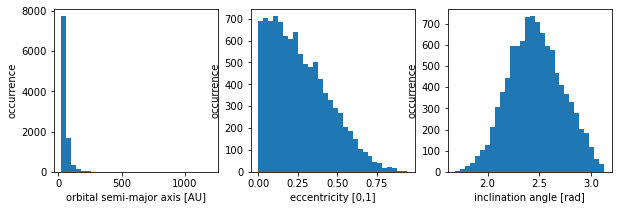

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt #Can't forget about matplotlob :) 

ecc = [x[s.system.param_idx['ecc1']] for x in orbits1]  #pulling out eccentricity with orbitize
i = [x[s.system.param_idx['inc1']] for x in orbits1]    #pulling out Inclination angle in Radians
sma = [x[s.system.param_idx['sma1']] for x in orbits1]  #pulling out Semi-major axis in AU

plt.figure(figsize=(10,3))                              #Set the figure size
plt.subplot(131)                                        #Order of the subplot (1row, 3 plots, 1st plot)
plt.hist(sma, bins=30)                                  #plot Histogram for Semi-major axis with a bin of 30
plt.xlabel('orbital semi-major axis [AU]')              #X-axis label
plt.ylabel('occurrence')                                #Y-axis label

plt.subplot(132)
plt.hist(ecc, bins=30)
plt.xlabel('eccentricity [0,1]')
plt.ylabel('occurrence')

plt.subplot(133)
plt.hist(i, bins=30)
plt.xlabel('inclination angle [rad]')
plt.ylabel('occurrence')

plt.show()

Corner plot:

In [12]:
#orbitize.results is a results class that contains plotting capabilites for corner plots and orbits plots
myResults = s.results  #myResults now contains everything we need to plot a corner plot and a plot of all the orbits

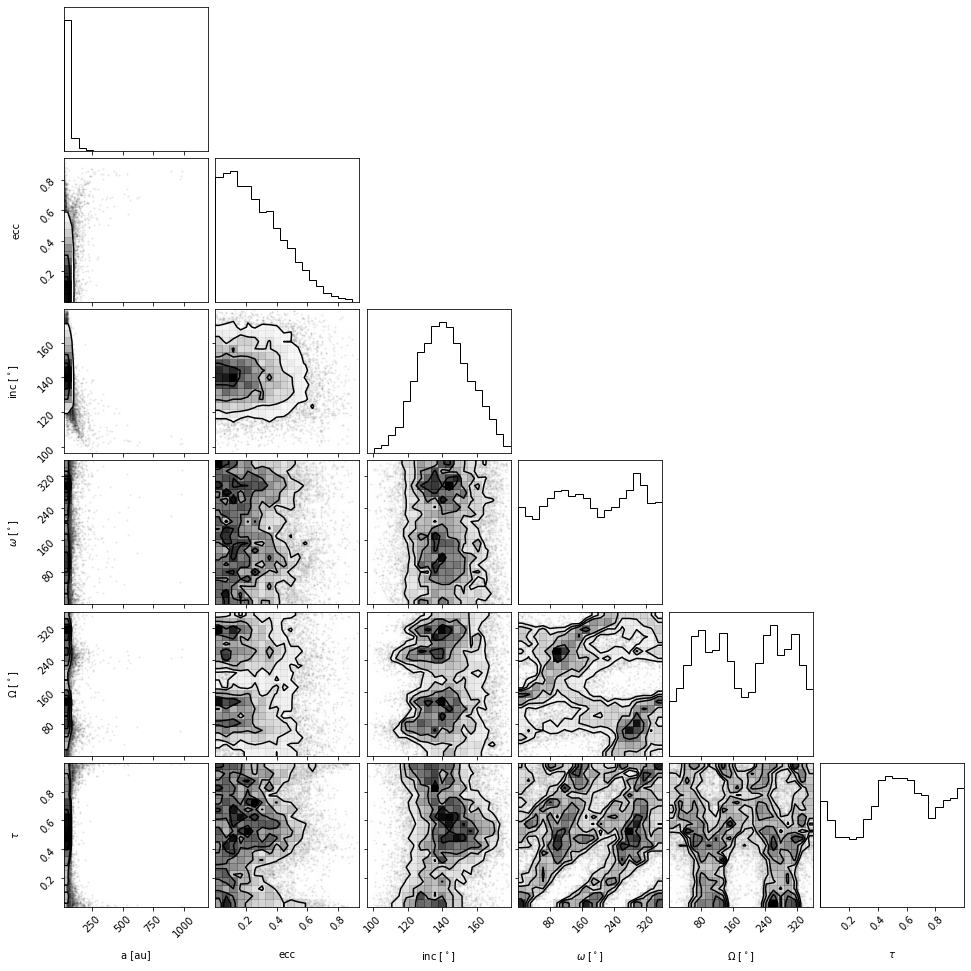

In [13]:
#Corner Plot is created here
corner_figure = myResults.plot_corner(param_list=['sma1', 'ecc1', 'inc1', 'aop1', 'pan1','tau1'])

Pretty cool right? What about the actual orbits? Let's see them already!

Orbit Plot

WARNING

The warning you see here is expected. It thinks some of the input dates may be in the wrong format b/c its computing some really far into the future dates but in this case our input dates are in the correct format which is in MJD


: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)" [astropy._erfa.core]


<Figure size 1008x432 with 0 Axes>

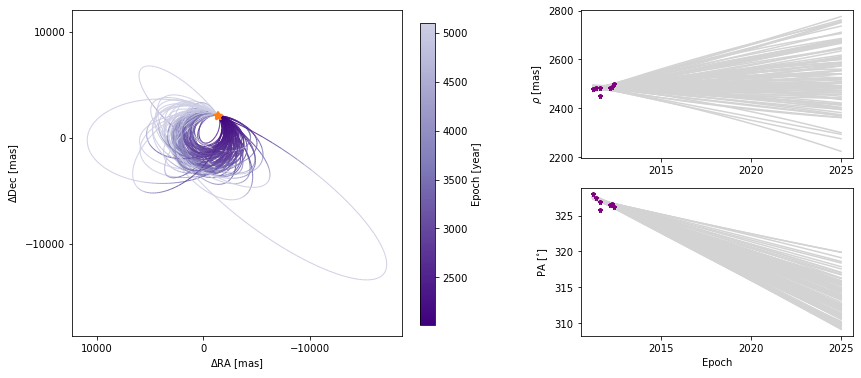

In [14]:
epochs = myDriver.system.data_table['epoch'] #You'll need to pull out the epochs

orbit_figure = myResults.plot_orbits(
    start_mjd=epochs[0] # Minimum MJD for colorbar (here we choose first data epoch)
)
print("The warning you see here is expected. It thinks some of the input dates may be in the wrong format b/c its computing some really far into the future dates but in this case our input dates are in the correct format which is in MJD")